In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
data_signal = pd.read_csv("data_signal.csv")
data_backgr = pd.read_csv("data_backgr.csv")

In [4]:
frames = [data_signal, data_backgr]
data = pd.concat(frames)
data = shuffle(data)
data.shape

(1170797, 58)

In [5]:
y = data.dnn_truth_value
X = data.drop('dnn_truth_value', axis=1)
X.shape, y.shape

((1170797, 57), (1170797,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy, AUC
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number GPUs availbale: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number GPUs availbale:  1


In [16]:
clf_nn = Sequential([
                    Dense(units=212, input_shape=(57,), activation='softplus', kernel_regularizer=l1(0.001)),
                    # Dense(units=229, activation='relu'),
                    Dense(units=212, activation='softplus'),
                    Dense(units=212, activation='softplus'),
                    Dense(units=212, activation='softplus'),
                    Dense(units=212, activation='softplus'),
                    Dense(units=212, activation='softplus'),
                    Dense(units=1, activation='sigmoid')
])

In [17]:
clf_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 212)               12296     
                                                                 
 dense_8 (Dense)             (None, 212)               45156     
                                                                 
 dense_9 (Dense)             (None, 212)               45156     
                                                                 
 dense_10 (Dense)            (None, 212)               45156     
                                                                 
 dense_11 (Dense)            (None, 212)               45156     
                                                                 
 dense_12 (Dense)            (None, 212)               45156     
                                                                 
 dense_13 (Dense)            (None, 1)                

In [18]:
clf_nn.compile(optimizer=SGD(learning_rate=0.01),
               loss='binary_crossentropy',
               metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [19]:
history = clf_nn.fit(x=X_train, 
                     y=y_train, 
                     batch_size=2048,
                     epochs=200,
                     shuffle=True,
                     validation_split=0.1,
                     verbose=0)

2023-03-13 12:44:38.288216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-13 12:44:48.656667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [28]:
clf_nn.evaluate(X_test, y_test)

12074/12074 [==============================] - 157s 13ms/step - loss: 0.3769 - accuracy: 0.8406 - precision: 0.8607 - recall: 0.9375 - auc: 0.8806


[0.376924604177475,
 0.840611457824707,
 0.8607309460639954,
 0.9375432729721069,
 0.8806498646736145]

In [20]:
df = pd.DataFrame(history.history)

Text(0.5, 0, 'epoch')

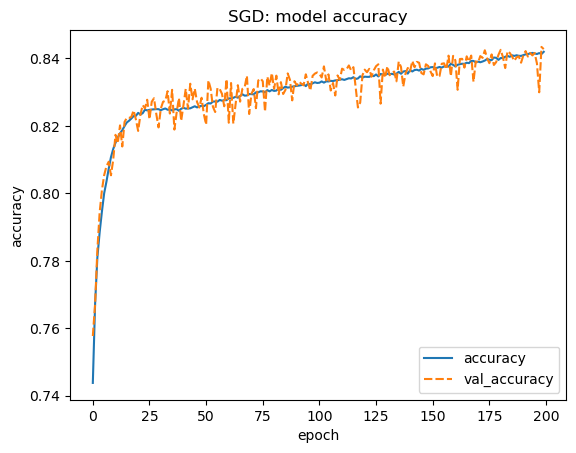

In [21]:
import matplotlib.pyplot as plt
sns.lineplot(data=df[['accuracy', 'val_accuracy']])
plt.title('SGD: model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

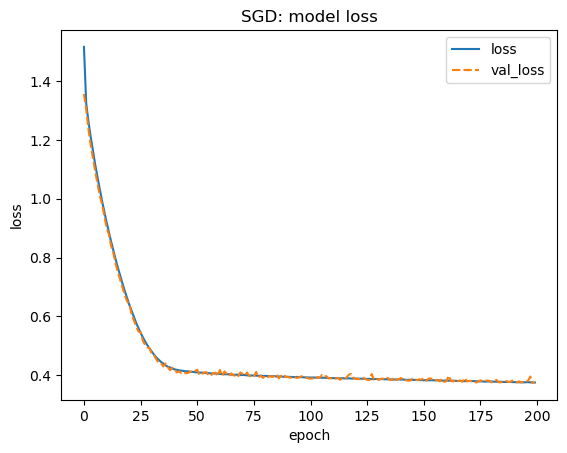

In [22]:
sns.lineplot(data=df[['loss', 'val_loss']])
plt.title('SGD: model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

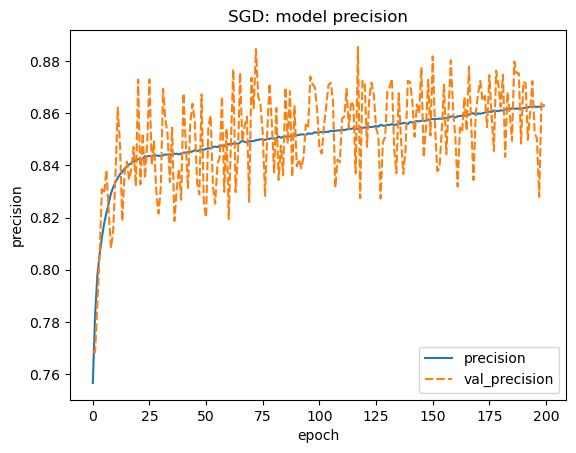

In [23]:
sns.lineplot(data=df[['precision', 'val_precision']])
plt.title('SGD: model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

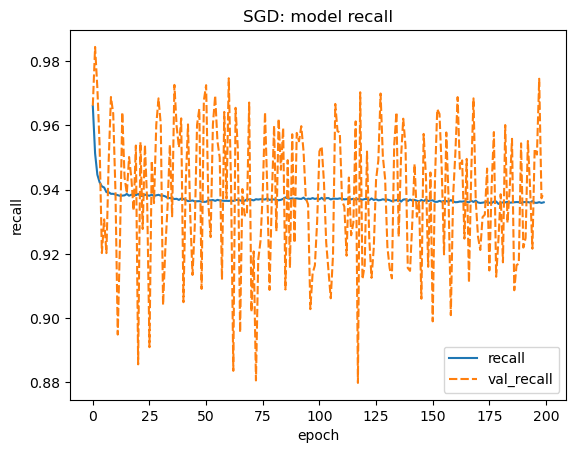

In [24]:
sns.lineplot(data=df[['recall', 'val_recall']])
plt.title('SGD: model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

In [26]:
class_names = ['signal', 'background']
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = np.where(y_prob < 0.5, 0, 1)
    return y_pred

classifier = estimator(clf_nn, class_names)

   26/12074 [..............................] - ETA: 1:15

2023-03-13 13:34:16.008504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12074/12074 [==============================] - 67s 6ms/step
Confusion matrix, without normalization
[[ 55183  43622]
 [ 17960 269599]]
12074/12074 [==============================] - 66s 5ms/step
Normalized confusion matrix
[[0.55850412 0.44149588]
 [0.06245675 0.93754325]]


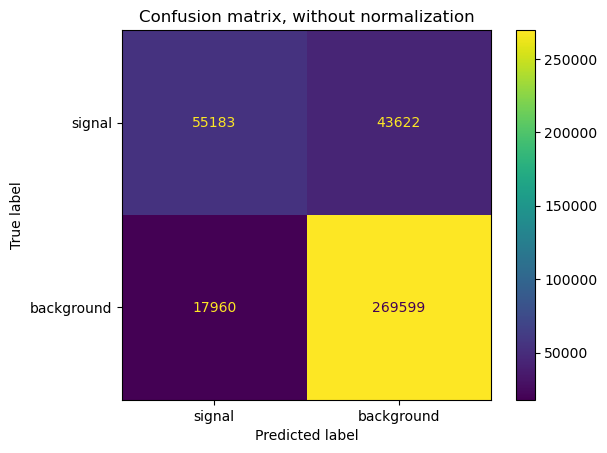

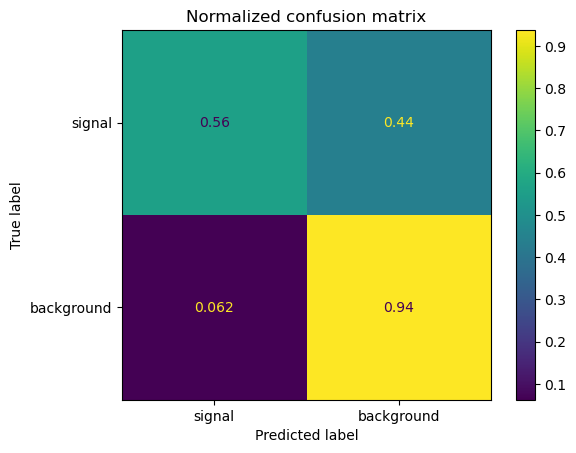

In [27]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.viridis,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [29]:
y_pred = clf_nn.predict(X_test)

12074/12074 [==============================] - 66s 5ms/step


In [23]:
len(y_test) == len(y_pred)

True

In [30]:
from sklearn.metrics import confusion_matrix

In [38]:
n_backgr = len(y_pred[y_pred > 0.5])
n_signal = len(y_pred[y_pred < 0.5])
n_backgr + n_signal == len(y_test)

True

In [40]:
n_backgr

308248

In [29]:
len(y_test)

386364

In [31]:
y_classes = np.where(y_pred < 0.5, 0, 1)

In [31]:
y_classes.reshape(-1)

array([1, 1, 0, ..., 0, 1, 0])

In [43]:
confusion_matrix(y_test, y_classes, normalize='true')

array([[0.55850412, 0.44149588],
       [0.06245675, 0.93754325]])

In [44]:
confusion_matrix(y_test, y_classes)

array([[ 55183,  43622],
       [ 17960, 269599]])